In [1]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pkl
import itertools

from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt

### Read the graph and the data

In [2]:
data_ab  = pd.read_csv("../../../generated_csvs/abortion_daily_polarities_base.csv")
graph_ab = nx.read_gexf("../../../graph/abortion_daily_largest.gexf")

### Divide the data into classes

In [3]:
# n_classes can be 2, 4, 6 or 8
n_classes = 2

# polarity_type can be either "Polarity Neighbours" or "Polarity Following"
polarity_type = "Polarity Following"

In [4]:
base_polarities = data_ab[polarity_type].dropna()
base_polarities[base_polarities > 2.42]  = 2.42
base_polarities[base_polarities < -2.42] = -2.42

if n_classes == 2:
    base_polarities = base_polarities.to_frame()
    base_polarities['Class'] = 0
    base_polarities['Class'][base_polarities[polarity_type] >= 0] = 1
    
elif n_classes == 4:
    base_polarities = base_polarities.to_frame()
    base_polarities['Class'] = 0

    base_polarities['Class'][base_polarities[polarity_type] >= 0] = 1
    positive_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] >= 0], q = 0.5)
    
    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles] = 2

    base_polarities['Class'][base_polarities[polarity_type] < 0] = 3
    negative_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] < 0], q = 0.5)
    
    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles] = 4
    
    
elif n_classes == 6:
    base_polarities = base_polarities.to_frame()
    base_polarities['Class'] = 0

    base_polarities['Class'][base_polarities[polarity_type] >= 0] = 1
    positive_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] >= 0], q = [0.33, 0.66])

    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles[0]] = 2
    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles[1]] = 3

    base_polarities['Class'][base_polarities[polarity_type] < 0] = 4
    negative_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] < 0], q = [0.33, 0.66])

    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles[1]] = 5
    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles[0]] = 6
    
    
elif n_classes == 8:
    base_polarities = base_polarities.to_frame()
    base_polarities['Class'] = 0

    base_polarities['Class'][base_polarities[polarity_type] >= 0] = 1
    positive_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] >= 0], q = [0.25, 0.5, 0.75])

    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles[0]] = 2
    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles[1]] = 3
    base_polarities['Class'][base_polarities[polarity_type] >= positive_quantiles[2]] = 4

    base_polarities['Class'][base_polarities[polarity_type] < 0] = 5
    negative_quantiles = np.quantile(base_polarities[polarity_type][base_polarities[polarity_type] < 0], q = [0.25, 0.5, 0.75])

    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles[2]] = 6
    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles[1]] = 7
    base_polarities['Class'][base_polarities[polarity_type] <= negative_quantiles[0]] = 8

/home/adc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Get the features

In [5]:
# relabel nodes as indexes
d  = dict(zip(data_ab['0'].values, data_ab['0'].index))
g2 = nx.relabel_nodes(graph_ab, d)

#### Use the node degrees as features

In [6]:
features_idx = np.load("../../../npy/abortion_daily/index.npy", allow_pickle = True)
features_mat = np.load("../../../npy/abortion_daily/node_features_pca.npy", allow_pickle = True)

In [7]:
map_nodes_to_features = {}
for idx, feature in zip(range(0, len(features_idx)), features_idx):
    map_nodes_to_features[d[feature]] = idx
    
for i in list(g2.nodes()):
    g2.nodes[i]['features'] = features_mat[map_nodes_to_features[i]]
    
for node in list(g2.nodes()):
    g2.node[node]['label'] = 'default'

#### Alternative: use the eigenvectors as features

In [6]:
with open("../../../pickle/abortion_daily_eig.pkl", 'rb') as _p:
    _, eigvec = pkl.load(_p)
    
map_nodes_to_eigvec = {}
for idx, node_name in zip(range(0, len(list(graph_ab.nodes()))), list(graph_ab.nodes())):
    map_nodes_to_eigvec[d[node_name]] = idx
    
for i in list(g2.nodes()):
    g2.nodes[i]['features'] = eigvec[map_nodes_to_eigvec[i], 1:]
    
for node in list(g2.nodes()):
    g2.node[node]['label'] = 'default'

#### Alternative 2: use both the node degrees and the eigenvectors as features

In [6]:
features_idx = np.load("../../../npy/abortion_daily/index.npy", allow_pickle = True)
features_mat = np.load("../../../npy/abortion_daily/node_features_pca.npy", allow_pickle = True)

map_nodes_to_features = {}
for idx, feature in zip(range(0, len(features_idx)), features_idx):
    map_nodes_to_features[d[feature]] = idx
    
with open("../../../pickle/abortion_daily_eig.pkl", 'rb') as _p:
    _, eigvec = pkl.load(_p)
    
map_nodes_to_eigvec = {}
for idx, node_name in zip(range(0, len(list(graph_ab.nodes()))), list(graph_ab.nodes())):
    map_nodes_to_eigvec[d[node_name]] = idx
    
for i in list(g2.nodes()):
    g2.nodes[i]['features'] = np.concatenate((features_mat[map_nodes_to_features[i]], eigvec[map_nodes_to_eigvec[i], 1:]))
    
for node in list(g2.nodes()):
    g2.node[node]['label'] = 'default'

### Train the model

In [7]:
# get the subgraph containing the known nodes
stellar = StellarGraph.from_networkx(g2, node_features = 'features')
subg    = stellar.subgraph(base_polarities['Class'].index)

In [8]:
train_labels, test_labels = model_selection.train_test_split(
    base_polarities['Class'],
    train_size=0.7,
    test_size=None,
    stratify=base_polarities['Class'],
    random_state=42,
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100,
)

In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

batch_size = 50
num_samples = [10, 10]

generator = GraphSAGENodeGenerator(subg, batch_size, num_samples)
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

# choose the activation function and the loss based on the number of classes:
if n_classes == 2:
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)
    
    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )
    
else:
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    
    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    
val_gen = generator.flow(val_labels.index, val_targets)
history = model.fit(
    train_gen, epochs=20, validation_data=val_gen, verbose=2, shuffle=False
)

Epoch 1/20
872/872 - 112s - loss: 0.4807 - acc: 0.7654 - val_loss: 0.4432 - val_acc: 0.7938
Epoch 2/20
872/872 - 113s - loss: 0.4488 - acc: 0.7853 - val_loss: 0.4421 - val_acc: 0.7963
Epoch 3/20
872/872 - 115s - loss: 0.4414 - acc: 0.7881 - val_loss: 0.4373 - val_acc: 0.8003
Epoch 4/20
872/872 - 116s - loss: 0.4326 - acc: 0.7939 - val_loss: 0.4306 - val_acc: 0.8035
Epoch 5/20
872/872 - 117s - loss: 0.4326 - acc: 0.7926 - val_loss: 0.4339 - val_acc: 0.8016
Epoch 6/20
872/872 - 115s - loss: 0.4287 - acc: 0.7939 - val_loss: 0.4333 - val_acc: 0.7957
Epoch 7/20
872/872 - 116s - loss: 0.4268 - acc: 0.7942 - val_loss: 0.4346 - val_acc: 0.7979
Epoch 8/20
872/872 - 116s - loss: 0.4257 - acc: 0.7971 - val_loss: 0.4272 - val_acc: 0.8032
Epoch 9/20
872/872 - 115s - loss: 0.4236 - acc: 0.7976 - val_loss: 0.4312 - val_acc: 0.7989
Epoch 10/20
872/872 - 115s - loss: 0.4225 - acc: 0.7987 - val_loss: 0.4315 - val_acc: 0.7971
Epoch 11/20
872/872 - 119s - loss: 0.4187 - acc: 0.8013 - val_loss: 0.4340 - va

In [10]:
# Save the train / validation training history
history_save_path = "../../../npy/classifier_history/abortion_daily/history_2_following_concatenate.npy"
np.save(history_save_path, history.history)

### Test the model

In [11]:
test_gen = generator.flow(test_labels.index, test_targets)

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

299/299 [==============================] - 31s 104ms/step - loss: 0.4302 - acc: 0.7987

Test Set Metrics:
	loss: 0.4302
	acc: 0.7987


### Predict the unlabeled data

In [13]:
generator = GraphSAGENodeGenerator(stellar, batch_size, num_samples)

hold_out_nodes = data_ab.index.difference(base_polarities.index)

data_ab['Class'] = 0

hold_out_targets = target_encoding.transform(data_ab.loc[hold_out_nodes]["Class"])
hold_out_gen = generator.flow(hold_out_nodes, hold_out_targets)

hold_out_predictions = model.predict(hold_out_gen)
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

In [14]:
pred          = data_ab
pred['Class'] = base_polarities['Class']
pred.loc[hold_out_nodes, 'Class'] = hold_out_predictions

### Save the model and the predictions

In [15]:
model.save("../../../keras/abortion_daily/model")
pred[['0', 'Class']].to_csv("../../../keras/abortion_daily/predictions.csv", index = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../../keras/abortion_daily/model/assets


### TSNE visualization

In [16]:
all_nodes  = pred['Class'].index
all_mapper = generator.flow(all_nodes)

embedding_model = Model(inputs = x_inp, outputs = x_out)
emb = embedding_model.predict(all_mapper)

In [20]:
# save the embeddings
np.save("../../../npy/embeddings/abortion_daily/emb.npy", emb)

In [2]:
emb_trans = TSNE(n_components = 2, n_jobs = -1).fit_transform(emb)

In [18]:
colours = []
for iter in range(0, len(map_nodes_to_features)):
    if pred.loc[map_nodes_to_features[iter], 'Class'] == 0: 
        colours.append('b')
    
    else:
        colours.append('r')

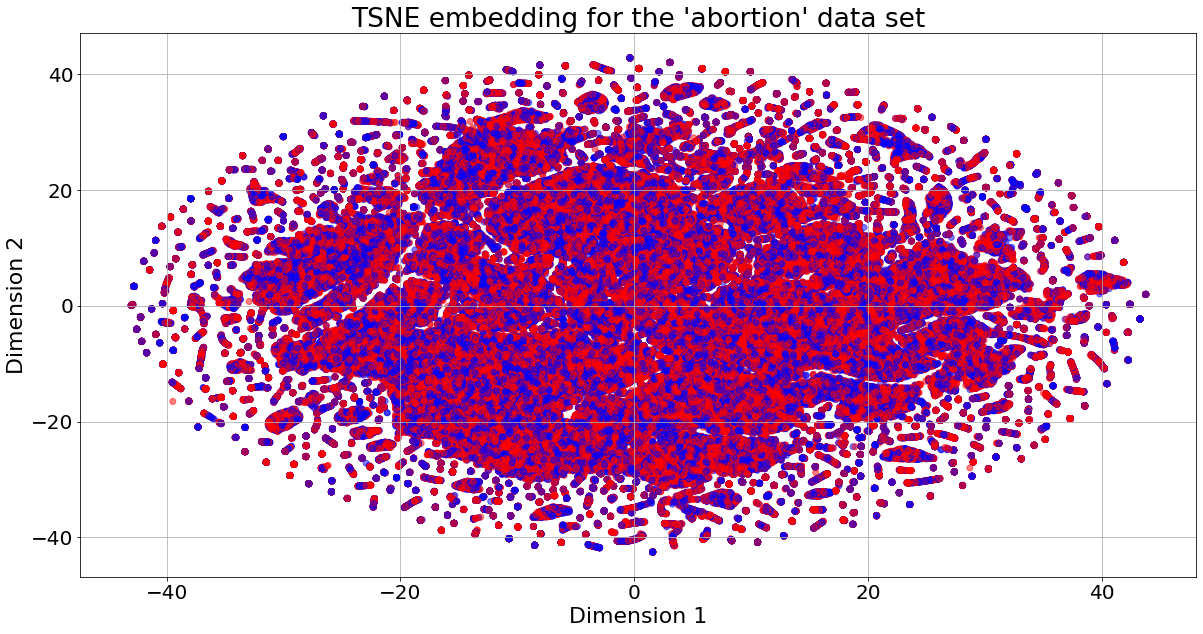

In [25]:
plt.figure(figsize = (20, 10))
plt.rcParams.update({'font.size': 22})
plt.scatter(emb_trans[:,0], emb_trans[:,1], c = colours, alpha = 0.5)
plt.tick_params(labelsize = 20)
plt.title("TSNE embedding for the 'abortion' data set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

In [26]:
plt.figure(figsize = (20, 10))
plt.rcParams.update({'font.size': 22})
plt.scatter(emb_trans[:,0], emb_trans[:,1], c = colours, alpha = 0.5)
plt.tick_params(labelsize = 20)
plt.title("TSNE embedding for the 'abortion' data set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()

plt.savefig("../../../plots/abortion_daily/tsne_30_neighbours.png")
plt.close()

#### Save map to features from node degree

In [15]:
with open("../../../keras/abortion_daily/map_nodes_to_features.pkl", "wb") as _pkl:
    pkl.dump(map_nodes_to_features, _pkl)

#### Save map to features from eigenvectors

In [16]:
with open("../../../keras/abortion_daily/map_nodes_to_eigvec.pkl", "wb") as _pkl:
    pkl.dump(map_nodes_to_eigvec, _pkl)